# CRACTERIZACIÓN DE UNA FORMA CON DESCRIPTORES DE PERIMETRO

## OBTENCIÓN DEL CONTORNO

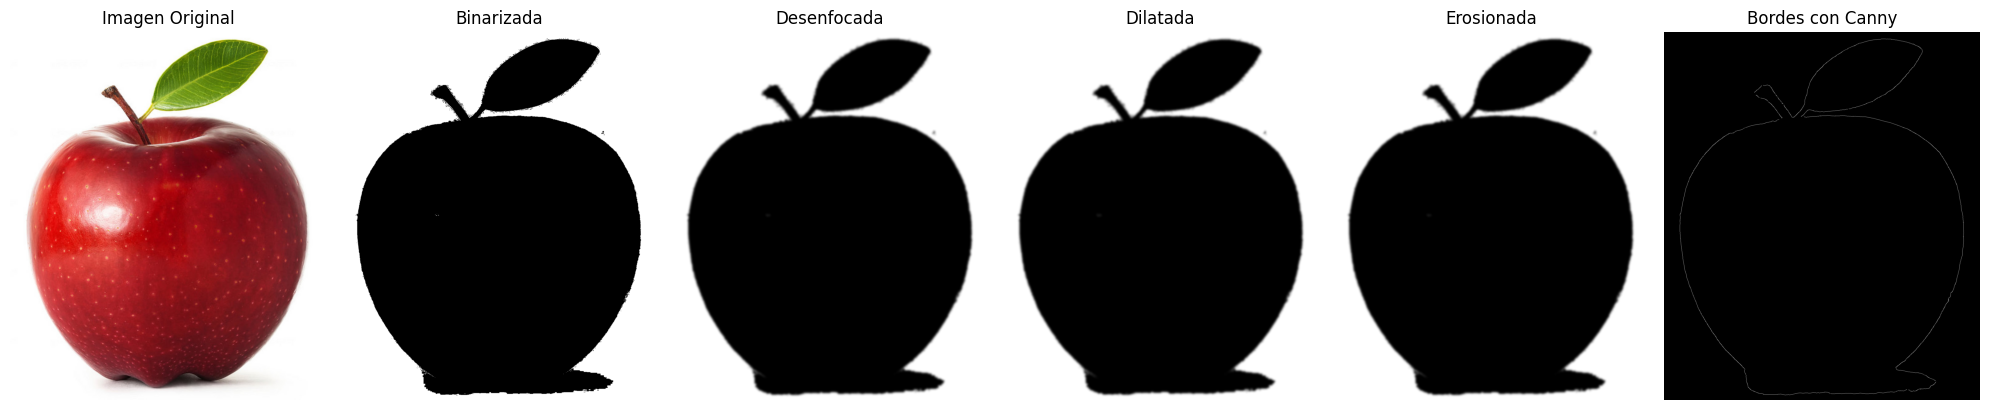

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen
imagen = cv2.imread('APL1.jpg')  # Reemplaza con la ruta de tu imagen
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para matplotlib

# Convertir a escala de grises
gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Binarizar la imagen (usar un umbral adaptativo o fijo)
_, binarizada = cv2.threshold(gris, 250, 255, cv2.THRESH_BINARY)

# Aplicar desenfoque Gaussiano para reducir ruido
desenfocada = cv2.GaussianBlur(binarizada, (31,31), 0)

# Crear un kernel para operaciones morfológicas
kernel = np.ones((3,3), np.uint8)  # Matriz de 3x3 de unos

# Aplicar dilatación
dilatada = cv2.dilate(desenfocada, kernel, iterations=1)

# Aplicar erosión
erosionada = cv2.erode(dilatada, kernel, iterations=1)

# Aplicar el detector de bordes Canny después de la erosión
bordes = cv2.Canny(erosionada, 50, 150)

# Mostrar imágenes con Matplotlib
fig, axs = plt.subplots(1, 6, figsize=(20, 5))

axs[0].imshow(imagen_rgb)  
axs[0].set_title("Imagen Original")
axs[0].axis("off")

axs[1].imshow(binarizada, cmap='gray')  
axs[1].set_title("Binarizada")
axs[1].axis("off")

axs[2].imshow(desenfocada, cmap='gray')  
axs[2].set_title("Desenfocada")
axs[2].axis("off")

axs[3].imshow(dilatada, cmap='gray')  
axs[3].set_title("Dilatada")
axs[3].axis("off")

axs[4].imshow(erosionada, cmap='gray')  
axs[4].set_title("Erosionada")
axs[4].axis("off")

axs[5].imshow(bordes, cmap='gray')  
axs[5].set_title("Bordes con Canny")
axs[5].axis("off")

plt.tight_layout()
plt.show()

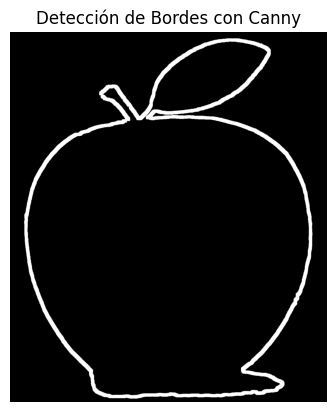

In [2]:
kernel = np.ones((3,3), np.uint8)
bordes_dilatados = cv2.dilate(bordes, kernel, iterations=7)
# Mostrar resultado
plt.imshow(bordes_dilatados, cmap='gray')
plt.title("Detección de Bordes con Canny")
plt.axis('off')
plt.show()

## DESCRIPTORES DE PERIMETRO

Descriptores de Fourier (primeros 10):
[2104011.        +2056189.j           23774.12857982 -282750.96388324j
  116943.14271628  -74923.73682807j   44617.61077931  +17485.37140814j
  103192.08109095  -40278.97706006j   20041.5121205   +66787.06747898j
    2167.5064546   -10710.87408595j  -52679.0700949   +20398.92963482j
  -33778.62943169  -16420.18793338j   19806.78983943  +45350.66511066j]

Momentos de Hu:
Hu[1] = 0.17055563991802652
Hu[2] = 0.0013189033507335316
Hu[3] = 0.0002226268466073436
Hu[4] = 2.4050460812442954e-05
Hu[5] = 1.7291636943616059e-09
Hu[6] = 7.441120314403224e-07
Hu[7] = -3.2716895146990573e-10


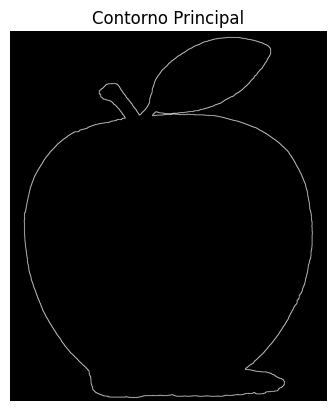

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que ya tienes 'bordes_dilatados' del código anterior.

# Encontrar contornos
contornos, _ = cv2.findContours(bordes_dilatados, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Seleccionar el contorno más grande (o el primero)
contorno_principal = max(contornos, key=cv2.contourArea)

# Obtener los descriptores de Fourier
contorno_complex = np.array([p[0][0] + 1j * p[0][1] for p in contorno_principal])  # Convertir a números complejos
descriptores_fourier = np.fft.fft(contorno_complex)  # Transformada de Fourier

# Obtener los momentos de Hu
momentos = cv2.moments(contorno_principal)  # Momentos espaciales
momentos_hu = cv2.HuMoments(momentos)  # Momentos de Hu

# Imprimir resultados
print("Descriptores de Fourier (primeros 10):")
print(descriptores_fourier[:10])

print("\nMomentos de Hu:")
for i, momento in enumerate(momentos_hu):
    print(f"Hu[{i + 1}] = {momento[0]}")

# Visualizar el contorno principal
imagen_contorno = np.zeros_like(bordes_dilatados)
cv2.drawContours(imagen_contorno, [contorno_principal], -1, 255, 2)

plt.imshow(imagen_contorno, cmap='gray')
plt.title("Contorno Principal")
plt.axis('off')
plt.show()


## OBTENCIÓN DEL CSV

Los descriptores geométricos se han guardado en el archivo: descriptores_forma.csv


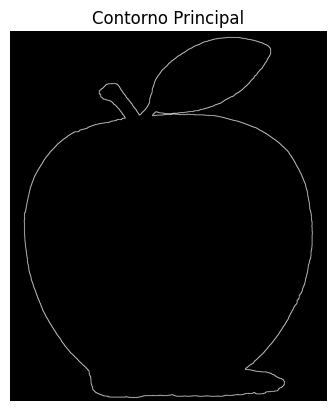

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

# Suponiendo que ya tienes 'bordes_dilatados' del código anterior.

# Encontrar contornos
contornos, _ = cv2.findContours(bordes_dilatados, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Seleccionar el contorno más grande (o iterar sobre todos si hay varios)
contorno_principal = max(contornos, key=cv2.contourArea)

# Calcular características geométricas
area = cv2.contourArea(contorno_principal)
perimetro = cv2.arcLength(contorno_principal, True)
rectangulo = cv2.minAreaRect(contorno_principal)
ancho, alto = rectangulo[1]
aspect_ratio = ancho / alto if alto != 0 else 0
compactibilidad = (4 * np.pi * area) / (perimetro ** 2) if perimetro != 0 else 0
convexidad = cv2.isContourConvex(contorno_principal)
hull = cv2.convexHull(contorno_principal)
solidez = area / cv2.contourArea(hull) if cv2.contourArea(hull) != 0 else 0
momentos = cv2.moments(contorno_principal)
cx = momentos['m10'] / momentos['m00'] if momentos['m00'] != 0 else 0
cy = momentos['m01'] / momentos['m00'] if momentos['m00'] != 0 else 0
momentos_hu = cv2.HuMoments(momentos).flatten()

# Guardar los descriptores en un diccionario
descriptores = {
    "Area": area,
    "Perimetro": perimetro,
    "Aspect_Ratio": aspect_ratio,
    "Compactibilidad": compactibilidad,
    "Convexidad": convexidad,
    "Solidez": solidez,
    "Centroide_X": cx,
    "Centroide_Y": cy,
}

# Agregar momentos de Hu al diccionario
for i, hu in enumerate(momentos_hu):
    descriptores[f"Hu[{i+1}]"] = hu

# Nombre del archivo CSV
nombre_archivo = "descriptores_forma.csv"
archivo_existe = os.path.isfile(nombre_archivo)

# Guardar en CSV, agregando datos si ya existe
with open(nombre_archivo, mode="a", newline="") as archivo_csv:
    escritor = csv.writer(archivo_csv)
    
    # Escribir encabezados solo si el archivo no existe
    if not archivo_existe:
        escritor.writerow(descriptores.keys())
    
    # Escribir los valores de los descriptores
    escritor.writerow(descriptores.values())

# Imprimir mensaje de éxito
print(f"Los descriptores geométricos se han guardado en el archivo: {nombre_archivo}")

# Visualizar el contorno principal
imagen_contorno = np.zeros_like(bordes_dilatados)
cv2.drawContours(imagen_contorno, [contorno_principal], -1, 255, 2)

plt.imshow(imagen_contorno, cmap='gray')
plt.title("Contorno Principal")
plt.axis('off')
plt.show()

